# Programming Assignment 2 by Zach Hatzenbeller

#### Problem 1 Imports

In [1]:
# Part 1 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Part 2 imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
import unittest
from parameterized import parameterized

#### Problem 2 Imports

In [3]:
# Part 1 Imports
from scipy.stats import chi2

In [4]:
# Part 2 Imports
import seaborn as sns
from itertools import combinations
import math
from matplotlib import patches

In [5]:
# Part 3 Imports
from sklearn.utils import shuffle

## Problem 1 - Feature Ranking Methods (FLDR, Decision Tree Classification)

### Part 1

In [6]:
# Load the data
mnist = pd.read_csv("trainFeatures42k.csv")
X = mnist.values[:,1:]
y = mnist.values[:,0]

In [7]:
# Class to calculate the fischer score to rank features
def fisher_score(X, y, sorted=False):
    # Find unique classes and number of features
    classes = np.unique(y)
    n_features = X.shape[1]
    
    # Overall mean of each feature
    mean_overall = np.mean(X, axis=0)
    
    # Initialize S_B (between-class variance) and S_W (within-class variance)
    S_B = np.zeros(n_features)
    S_W = np.zeros(n_features)
    
    # Calculate S_B and S_W for each feature
    for c in classes:
        X_c = X[y == c]  # Data points for class c
        mean_c = np.mean(X_c, axis=0)  # Mean of each feature for class c
        n_c = X_c.shape[0]  # Number of data points in class c
        
        # Update between-class and within-class variances
        S_B += n_c * (mean_c - mean_overall) ** 2
        S_W += np.sum((X_c - mean_c) ** 2, axis=0)
    
    # Compute Fisher Score: S_B / S_W
    with np.errstate(divide='ignore', invalid='ignore'):
        scores = S_B / S_W
        scores[np.isnan(scores)] = 0  # Set scores where S_W is zero to 0 (avoid division by zero)
    
    if sorted:
        return np.argsort(scores)[::-1]
    else:
        return scores

# Compute Fisher scores
ranked_features = fisher_score(X, y, sorted=True)
print("Features Sort by Importance:")
print(ranked_features)


Features Sort by Importance:
[41 40 20  2 42  0 21  4 22  6 44  3 11 51 43 46  7 23 45  1  5 48 27 10
 29 12 52 26 49 30 25 47 24 19 28 34 56 31 53  9 33 50 58 57 35 13  8 18
 39 15 55 32 36 59 14 16 54 38 37 17]


### Part 2

In [8]:
# Part 2A
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(X, y)
cross_val_score(clf, X, y, cv=5)

array([0.84892857, 0.8502381 , 0.84678571, 0.84404762, 0.84641029])

In [9]:
# Part 2B
def k_fold_cross_validation(X: np.ndarray, y: np.ndarray, k=5):
    fold_size = len(X) // k
    folds_x = {}
    folds_y = {}

    for i in range(k):
        start = i * fold_size
        end = start + fold_size
        folds_x[i] = X[start:end,:]
        folds_y[i] = y[start:end]

    for i in range(k):
        X_test = folds_x[i]
        y_test = folds_y[i]
        X_train = []
        y_train = []

        for j in range(k):
            if j != i:
                X_train.extend(folds_x[j].tolist())
                y_train.extend(folds_y[j].tolist())

        yield np.array(X_train), X_test, np.array(y_train), y_test

fold = 0
for X_train, X_test, y_train, y_test in k_fold_cross_validation(X, y, k=5):
    clf2 = DecisionTreeClassifier()
    clf2.fit(X_train, y_train)
    y_preds = clf2.predict(X_test)
    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_preds)}")
    fold += 1

Fold 0 Accuracy: 0.8502202643171806
Fold 1 Accuracy: 0.85010120252411
Fold 2 Accuracy: 0.8462912251458506
Fold 3 Accuracy: 0.8429574949398738
Fold 4 Accuracy: 0.8481962138349803


In [10]:
# Part 2C
decision_tree_features = np.argsort(model.feature_importances_)[::-1]
print("Features Sort by Importance:")
print(decision_tree_features)

Features Sort by Importance:
[20 40 42 41  0  2 43  3  1 48 46 44 22 49 51 45 50 21  4  9 47 29  6 31
 57 11 28  5  7 56 23 25 52 24 58 54  8 26 59 12 30 33 53 10 35 14 16 34
 55 36 32 13 19 15 38 27 18 17 37 39]


In [11]:
# Part 2D
# UNIT TESTING STILL NEEDS TO BE IMPLEMENTED!!

# Outlier removal with Iris Dataset and Unit tests
df_iris = pd.read_csv("iris.csv")
iris_X = df_iris.iloc[:, :4].values
iris_y = df_iris.iloc[:,4].values

visual_ranking = [2,3,0,1]

def test_fischer_ranking():
    scores = list(fisher_score(iris_X, iris_y, sorted=True))
    if visual_ranking == scores:
        return "OK", scores
    else:
        return "Failed", scores

def test_classifier_ranking():
    clf2 = DecisionTreeClassifier(random_state=0)
    model2 = clf2.fit(iris_X, iris_y)
    decision_tree_features = list(np.argsort(model2.feature_importances_)[::-1])
    if visual_ranking == decision_tree_features:
        return "OK", decision_tree_features
    else:
        return "Failed", decision_tree_features

fischer_result, f_scores = test_fischer_ranking()
decision_result, d_scores = test_classifier_ranking()
print(f"Expected Visual Result: {visual_ranking}")
print(f"Fisher Linear Discriminant {fischer_result}: {f_scores}")
print(f"DecisionTreeClassifier {decision_result}: {d_scores}")

Expected Visual Result: [2, 3, 0, 1]
Fisher Linear Discriminant OK: [2, 3, 0, 1]
DecisionTreeClassifier Failed: [3, 2, 1, 0]


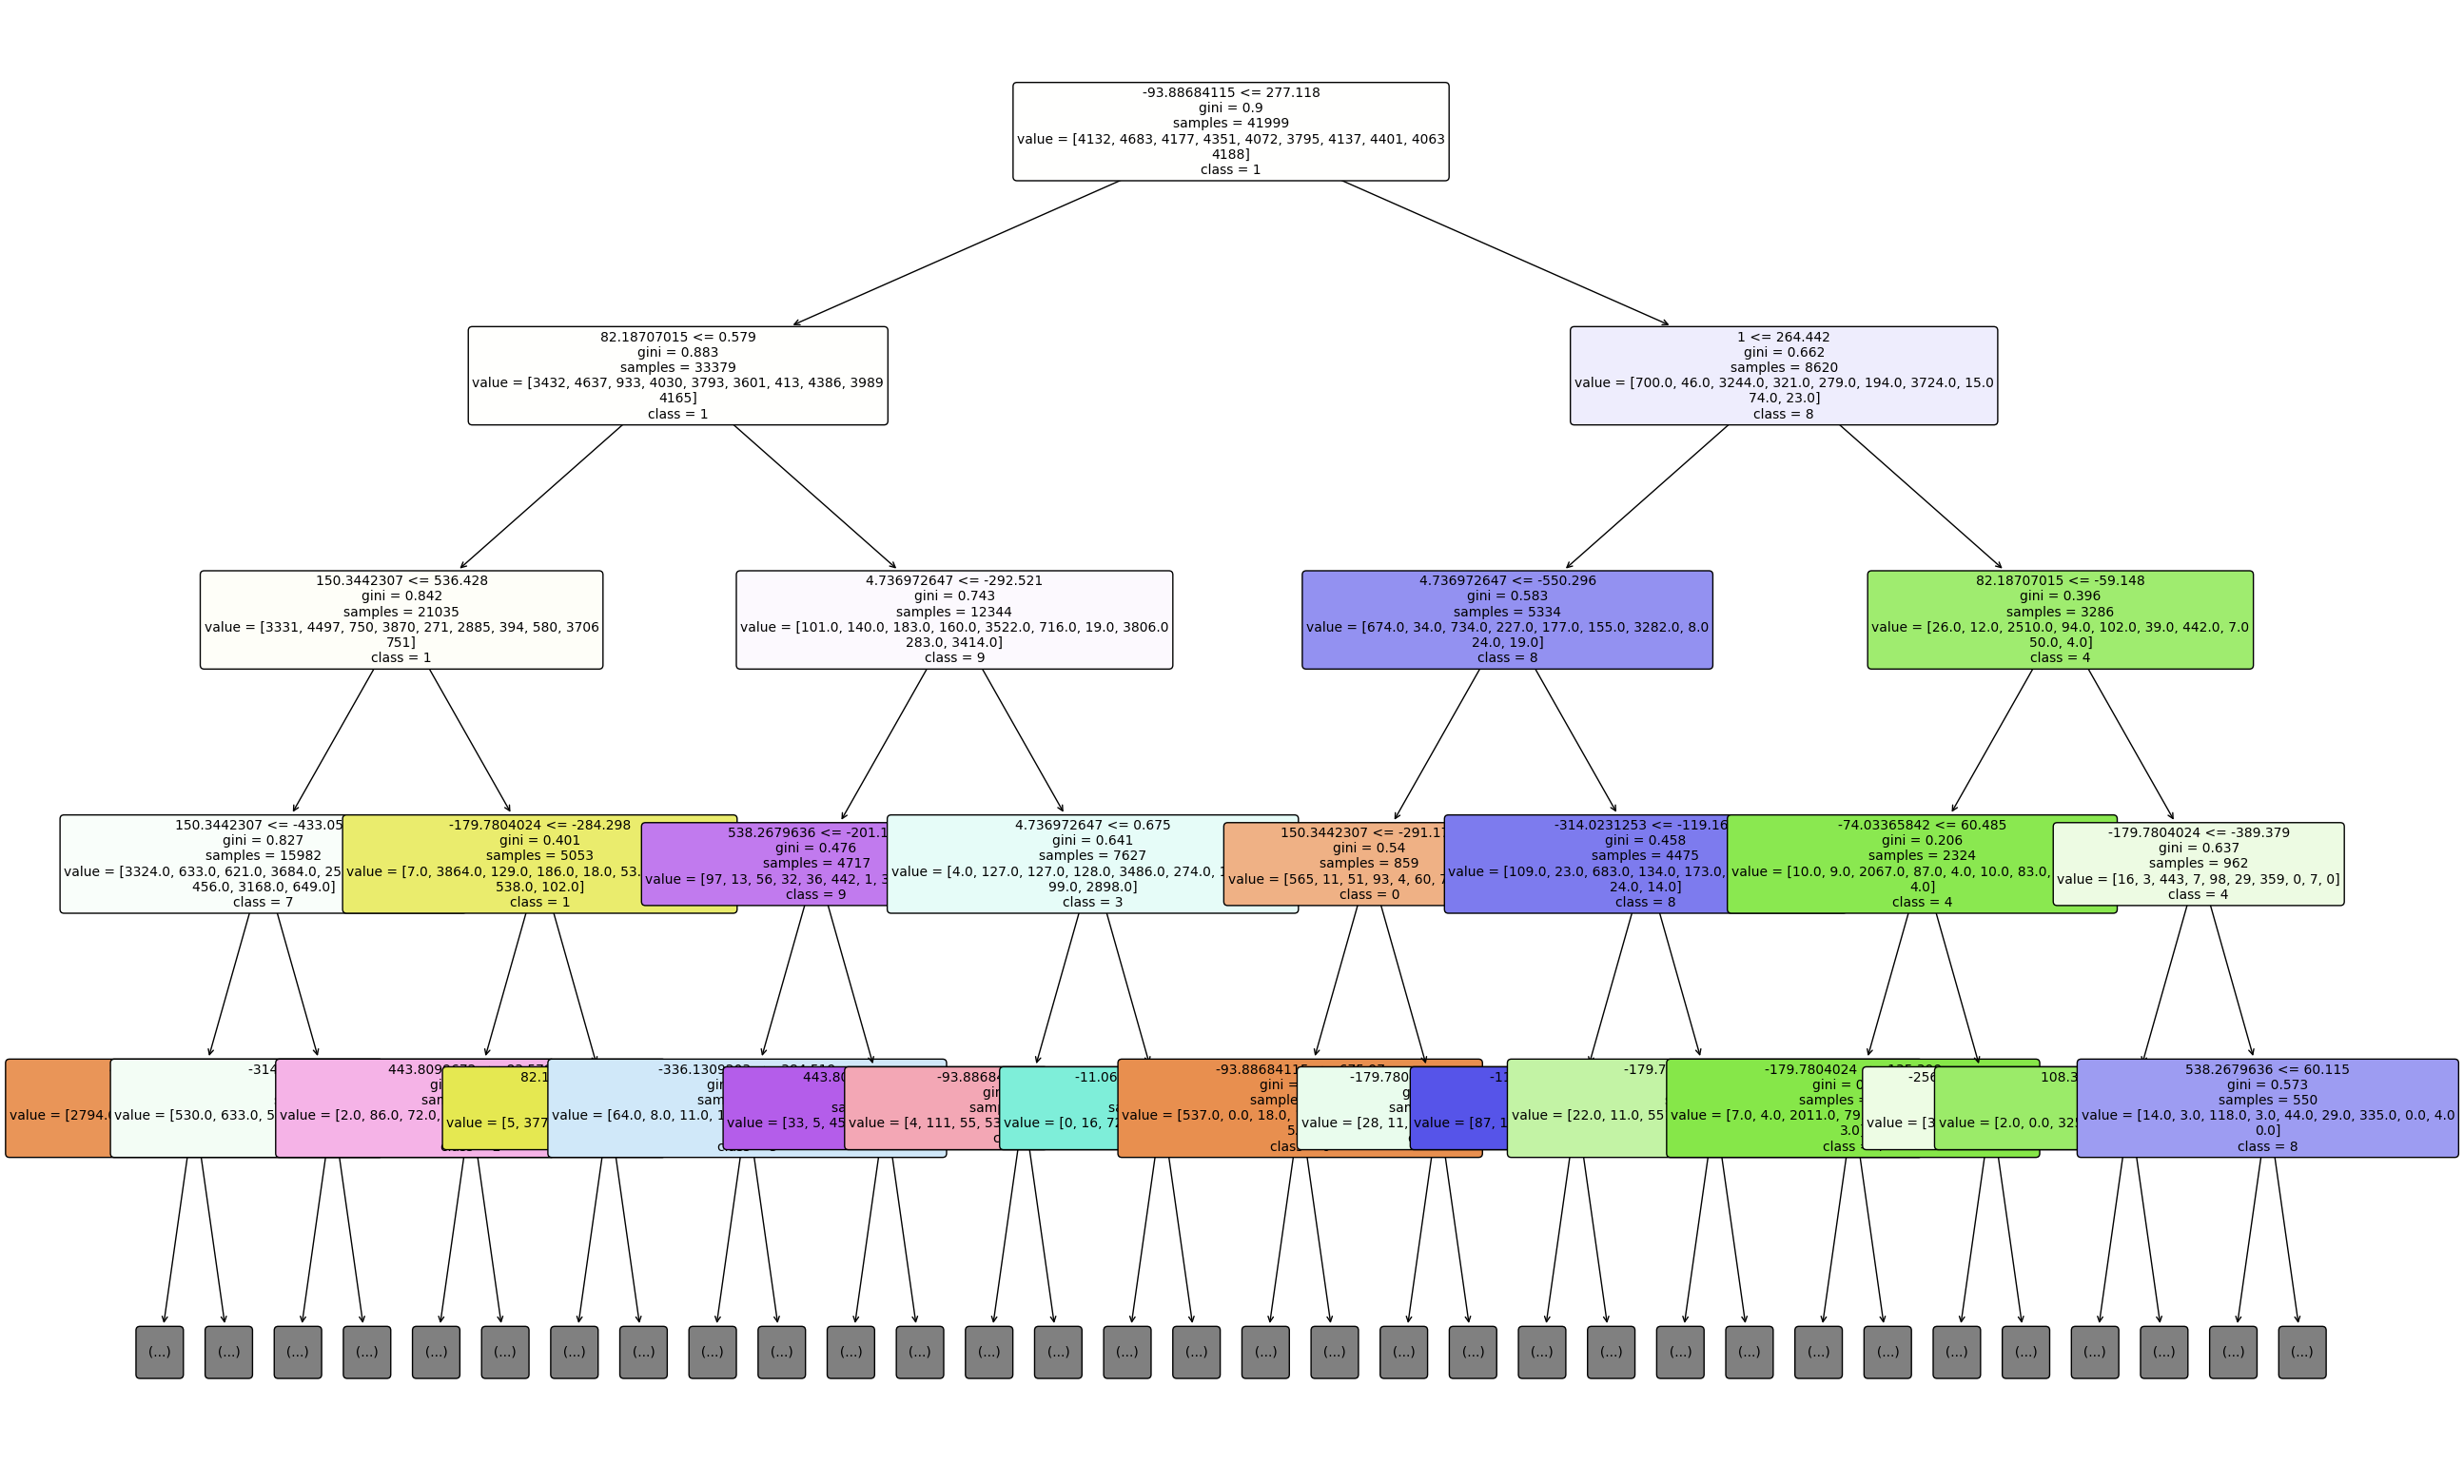

In [12]:
# Part 2E
target_labels = [str(i) for i in mnist.iloc[:,0].unique()]
plt.figure(figsize=(30,20))
tree.plot_tree(
    clf, 
    max_depth=4,
    filled=True,
    feature_names=mnist.columns,
    class_names=target_labels,
    rounded=True,
    fontsize=10
)
plt.show()

#### How `predict` Works

1. **Input Processing**:
   - The `predict` method takes an array of input features (test data). Each input instance (or sample) in the test data is independently passed down the tree.

2. **Traversing the Tree**:
   - Starting at the root node, the decision tree evaluates each input instance against the decision criteria stored in the nodes (typically, these are comparisons of feature values to thresholds).
   - Depending on the outcome of the evaluation, the decision path forks left or right, moving to the subsequent child node. This process repeats recursively until a leaf node is reached.

3. **Output Decision**:
   - Each leaf node in the decision tree contains the predicted class label (in classification tasks) or the predicted value (in regression tasks). This label or value is determined during the tree’s training phase, where the most common class or the average/mode of the target values in the training samples ending up in that leaf is stored.
   - Once a leaf node is reached, the stored prediction is output for the input instance.

#### Runtime Complexity Analysis

The runtime complexity of the `predict` method for decision trees depends primarily on two factors: the depth of the tree and the number of input features. The key points to consider are:

1. **Depth of the Tree (D)**:
   - The most crucial factor in determining the complexity. In the worst case, each sample's prediction requires traversing from the root to a leaf, which takes a number of steps equal to the depth of the tree.
   - Typically, the depth of a well-balanced binary decision tree is \(O(\log n)\) for `n` training samples, but can be as poor as \(O(n)\) in the worst case (e.g., in extremely unbalanced cases where the tree becomes a linked list).

2. **Number of Features (F)**:
   - At each node, a decision involves comparing a value from the input vector to a threshold, generally involving just one feature. However, the need to access specific positions in the input feature vector does introduce a dependency on the number of features, especially in terms of constant-time operations performed at each node.

3. **Number of Samples (S)**:
   - The runtime for predicting labels for `S` samples would generally be \(O(S \times D)\). In practice, for a fixed tree, as the number of samples increases, the total time linearly increases with the number of samples.


In [13]:
# Part 2F

**Decision Tree Feature Importances**:
- Measures how well a feature splits data based on information gain.
- Highly specific to the tree's structure; varies with data or model changes.
- Best for understanding feature effectiveness directly within tree-based models.

**Feature Ranking with Linear Discriminant Ratios (FLDR)**:
- Ranks features based on their ability to linearly discriminate between classes using statistical ratios.
- More stable across different datasets; assumes linear relationships and Gaussian distribution.
- Useful for identifying features that are statistically significant across models, especially linear ones.

**Comparison**:
- Decision tree importances are model-specific and reflect the tree's decision-making process, ideal for tree-based models.
- FLDR provides a broader, model-independent view, suitable for assessing general feature discriminability, particularly for linear models.

Both methods offer insights into feature importance but from different perspectives: one is model-specific and the other more general and statistically grounded.

##

## Problem 2 - Machine Learning

### Part 1

In [14]:
# Load the data
mnist = pd.read_csv("trainFeatures42k.csv")
X = mnist.values[:,1:]
y = mnist.values[:,0]

# Only keep 1000 observations per class, reduce complexity for machine learning algorithms
num_per_class = 1000
classes = np.unique(y)
reduced_x = np.zeros((num_per_class*classes.shape[0], X.shape[1]))
reduced_y = np.zeros(num_per_class*classes.shape[0])
for count, c in enumerate(classes):
    idx1 = np.where(y == c)[0]
    new_X = X[idx1][:num_per_class,:]
    new_y = y[idx1][:num_per_class]
    idx2 = count*num_per_class
    idx3 = idx2 + num_per_class 
    reduced_x[idx2:idx3, :] = new_X
    reduced_y[idx2:idx3] = new_y

X = reduced_x.copy()
y = reduced_y.copy()

In [15]:
# Part 1B, C, D

class PreProcessing:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        self.distances = {}
        self.removal_idx = []
        self.variance_ratio = 0

    def standard_scaler(self, feature):
        return (feature - np.mean(feature, axis=0)) / np.std(feature, axis=0) 

    def pca(self, data, n_components):
        # Standardize and Compute the covariance matrix
        # X_scaled = self.standard_scaler()
        X_scaled = data
        covariance_matrix = self.cov_matrix(X_scaled)

        # Compute eigenvalues and eigenvectors and sort
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Project data to lower dimensions
        eigenvectors_subset = sorted_eigenvectors[:, :n_components]
        projected_data = np.dot(X_scaled, eigenvectors_subset)

        # Calculate change in variance
        # Calculate total variance before projection
        total_variance_before = np.sum(np.var(X_scaled, axis=0, ddof=1))
        
        # Calculate total variance after projection (sum of selected eigenvalues)
        total_variance_after = np.sum(np.var(projected_data, axis=0, ddof=1))
        
        # Calculate change in variance
        variance_retained_ratio = total_variance_after / total_variance_before

        return projected_data, variance_retained_ratio
    
    def cov_matrix(self, data):
        row, col = data.shape
        cov_mat = np.zeros([col, col])

        for i in range(col):
            i_mean = np.mean(data[:,i])
            for j in range(col):
                j_mean = np.mean(data[:,j])
                cov_mat[i,j] = np.sum((data[:,i] - i_mean) * (data[:,j] - j_mean)) / (row - 1)
        return cov_mat

    def mahalanobis(self, y, data_mean, cov_inv):
        diff = y - data_mean
        left = np.dot(diff, cov_inv)
        mahalanobis_dist = np.sqrt(np.dot(left, diff.T))
        return mahalanobis_dist

    def outlier_removal_idx(self, distances, class_arr, training_arr, significance_level, dof):
        threshold = np.mean(distances) + 3*np.std(distances)
        threshold = chi2.ppf(1 - significance_level, df=dof)
        outlier_idx = np.array(distances)**2 > threshold
        outlier_vals = class_arr[outlier_idx]
        if outlier_vals.shape[0] != 0:
            outlier_idx = []
            for x in outlier_vals:
                outlier_idx.append(np.where((training_arr == x).all(axis=1))[0][0].tolist())
            return outlier_idx
        else:
            return []

    def fischer_score_helper(self):
        scores = fisher_score(self.X, self.y)
        return np.argsort(scores)[::-1]

    def clean_data(self, n_comps, feature_select=20, scale=False, significance_level=0.05, dof=None):
        cleaned_data = self.X.copy()
        if feature_select is not None:
            scores = self.fischer_score_helper()
            cleaned_data = cleaned_data[:, scores[:feature_select]]
        if n_comps is not None:
            cleaned_data, self.variance_ratio = self.pca(cleaned_data, n_comps)

        for class_ in self.classes:
            class_distance = []
            arr = cleaned_data[np.where(self.y==class_)[0]]
            mean_ = arr.mean(axis=0)
            covariance = self.cov_matrix(arr)
            cov_inv = np.linalg.inv(covariance)
            for idx in range(arr.shape[0]):
                class_distance.append(self.mahalanobis(arr[idx,:], mean_, cov_inv))
            self.distances[class_] = class_distance

        for key, dist in self.distances.items():
            class_arr = cleaned_data[np.where(self.y==key)[0]]
            if dof is None:
                index = self.outlier_removal_idx(dist, class_arr, cleaned_data, significance_level, dof=class_arr.shape[1])
            else:
                index = self.outlier_removal_idx(dist, class_arr, cleaned_data, significance_level, dof=dof)
            self.removal_idx.extend(index)

        self.X = np.delete(cleaned_data, self.removal_idx, axis=0)
        self.y = np.delete(self.y, self.removal_idx, axis=0)
        
        if scale:
            for idx in range(self.X.shape[1]):
                self.X[:,idx] = self.standard_scaler(self.X[:,idx])

# Scaling data generates worse score for variance ratio
# I chose not to scale the data as maintaining variance is important

n_comps=None
feature_select = (n_comps*2 if n_comps is not None else int(round(X.shape[1]/1.5,0)))
data_pre = PreProcessing(X, y)
data_pre.clean_data(n_comps=n_comps, feature_select=feature_select, scale=True, significance_level=0.01)
print("Data Normalization, Outlier Removal and Feature Ranking-Selection were used as Preprocessing methods")
if n_comps is not None:
    print(f"Variance Ratio after PCA: {data_pre.variance_ratio}")
print(f"Shape of new data: {data_pre.X.shape}")

Data Normalization, Outlier Removal and Feature Ranking-Selection were used as Preprocessing methods
Shape of new data: (8848, 40)


### Part 2

In [16]:
# Outlier removal with Iris Dataset and Unit tests
df_iris = pd.read_csv("iris.csv")
iris_X = df_iris.iloc[:, :4].values
iris_y = df_iris.iloc[:,4].values

iris_preprocessing = PreProcessing(iris_X, iris_y)
iris_preprocessing.clean_data(n_comps=None, feature_select=None, scale=False, significance_level=0.05, dof=4)
iris_preprocessing.removal_idx

[14, 22, 24, 41, 43, 68, 98, 118, 131]

Combinations of the Iris dataset Features for each class with a circle representing 5 standard deviations around the mean


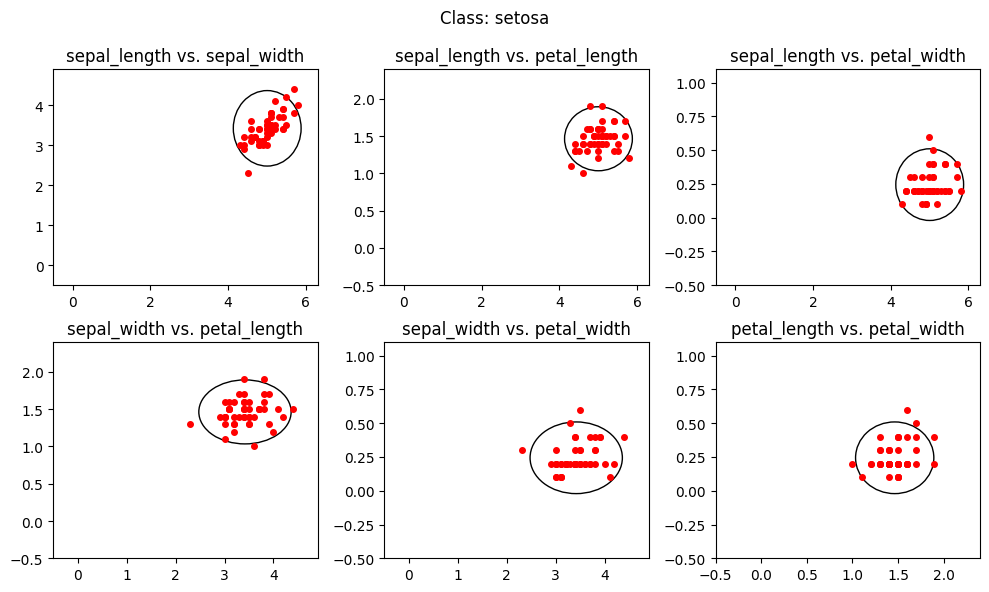

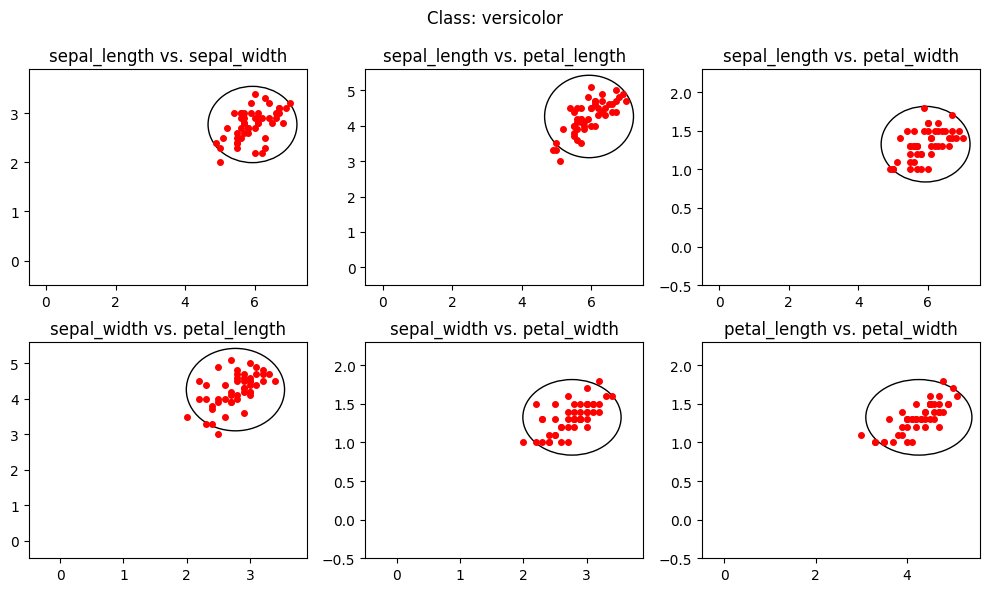

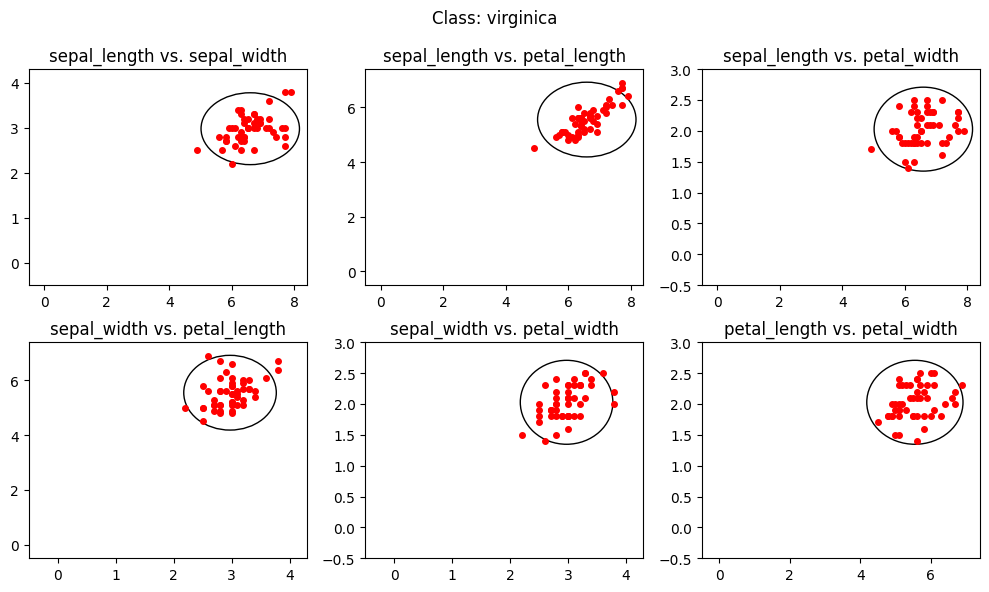

In [17]:
# Print combinations of features for each class
col_mapping = {
    0: "sepal_length",
    1: "sepal_width",
    2: "petal_length",
    3: "petal_width",
}
print("Combinations of the Iris dataset Features for each class with a circle representing 5 standard deviations around the mean")
for c in np.unique(iris_y):
    arr = iris_X[np.where(iris_y==c)]
    combos = math.comb(4,2)
    f, ax = plt.subplots(ncols=combos//2, nrows=2, figsize=(10,6))
    axes = ax.flatten()
    for count, i in enumerate(combinations(range(4),2)):
        max_x = max(arr[:,i[0]])
        max_y = max(arr[:,i[1]])
        mean_x = np.mean(arr[:,i[0]])
        mean_y = np.mean(arr[:,i[1]])
        std_x = np.std(arr[:,i[0]])*5
        std_y = np.std(arr[:,i[1]])*5
        axes[count].plot(arr[:,i[0]], arr[:,i[1]],"ro", markersize=4)
        axes[count].set_title(f"{col_mapping[i[0]]} vs. {col_mapping[i[1]]}")
        axes[count].add_patch(patches.Ellipse(xy=(mean_x, mean_y),width=std_x, height=std_y, color='k', linewidth=1, fill=False))
        axes[count].set_xlim(-0.5,max_x+0.5)
        axes[count].set_ylim(-0.5,max_y+0.5)
    plt.tight_layout()
    plt.suptitle(f"Class: {c}")
    f.subplots_adjust(top=0.88)


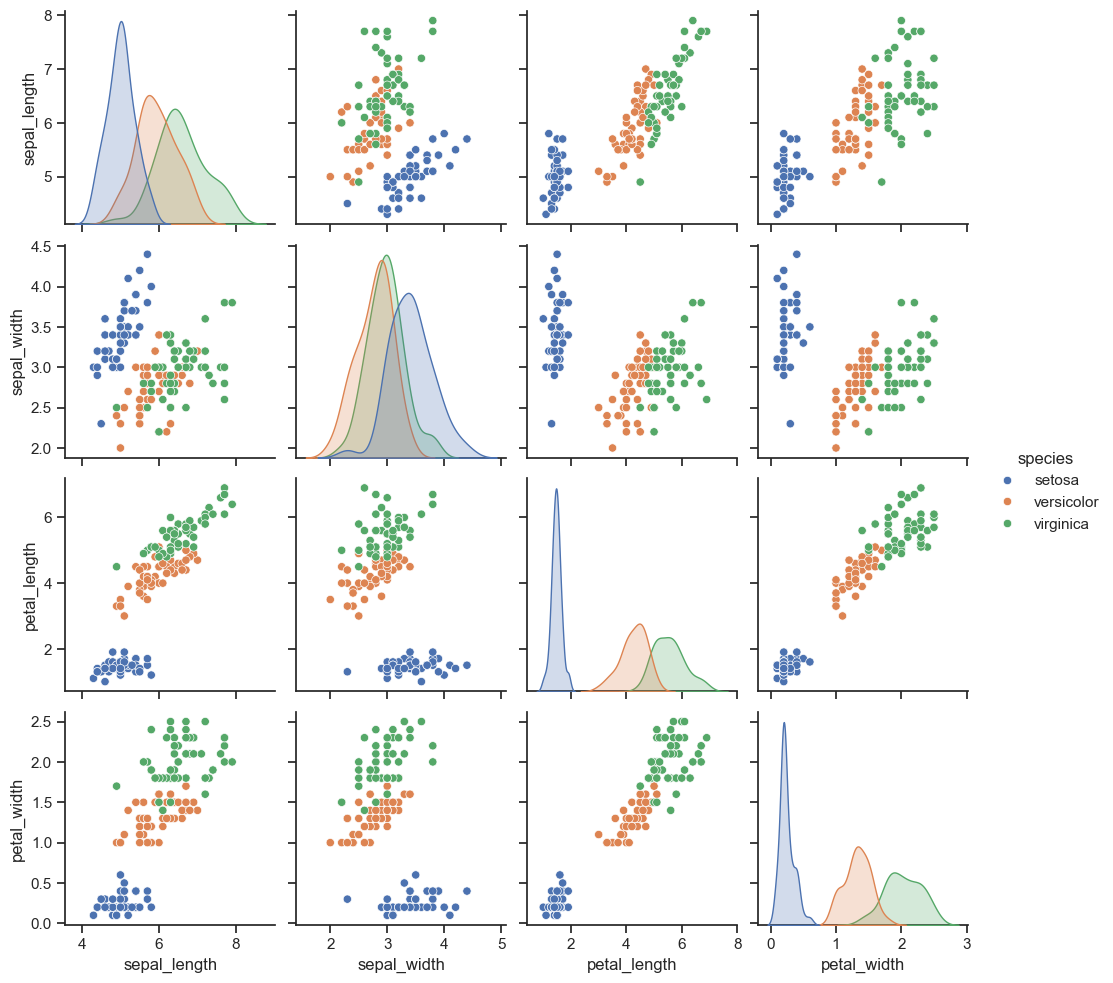

In [18]:
sns.set_theme(style="ticks")
sns.pairplot(df_iris, hue="species")

### Part 3

In [19]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        # Separate training data by class
        self.classes = np.unique(y)
        self.parameters = {}
        for cls in self.classes:
            X_cls = X[y == cls]
            self.parameters[cls] = {
                'mean': X_cls.mean(axis=0),
                'var': X_cls.var(axis=0) + 1e-5,  # Add small value to avoid division by zero
                'prior': X_cls.shape[0] / X.shape[0]
            }
            
    def predict(self, X):
        # Calculate the log probability for each class
        y_pred = []
        for x in X:
            class_probs = {}
            for cls, params in self.parameters.items():
                log_prior = np.log(params['prior'])
                log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * params['var'])) - 0.5 * np.sum(((x - params['mean']) ** 2) / params['var'])
                class_probs[cls] = log_prior + log_likelihood
            y_pred.append(max(class_probs, key=class_probs.get))
        return np.array(y_pred)

fold = 0
X_shuffled = shuffle(data_pre.X, random_state=42)
y_shuffled = shuffle(data_pre.y, random_state=42)
for X_train, X_test, y_train, y_test in k_fold_cross_validation(X_shuffled, y_shuffled, k=5):
    bayes22 = NaiveBayesClassifier()
    bayes22.fit(X_train, y_train)
    y_preds = bayes22.predict(X_test)
    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_preds, normalize=True)}")
    fold += 1

Fold 0 Accuracy: 0.9293386093838327
Fold 1 Accuracy: 0.9140757490107405
Fold 2 Accuracy: 0.9084228377614472
Fold 3 Accuracy: 0.9135104578858112
Fold 4 Accuracy: 0.9033352176370831


In [20]:
# Part 3B
class ParzenWindowClassifier:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X_train = None
        self.y_train = None
        self.classes = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)

    def gaussian_kernel(self, distance):
        h = self.bandwidth
        return (1 / (np.sqrt(2 * np.pi) * h)) * np.exp(- (distance ** 2) / (2 * h ** 2))

    def predict(self, X):
        predictions = []
        for x in X:
            # Calculate the distance from each point in X_train to x
            distances = np.linalg.norm(self.X_train - x, axis=1)
            # Compute densities
            densities = self.gaussian_kernel(distances)
            # Calculate density per class
            class_densities = {}
            for cls in self.classes:
                class_densities[cls] = np.sum(densities[self.y_train == cls])
            # Predict the class with the highest density
            predicted_class = max(class_densities, key=class_densities.get)
            predictions.append(predicted_class)
        return np.array(predictions)

fold = 0
X_shuffled = shuffle(data_pre.X, random_state=42)
y_shuffled = shuffle(data_pre.y, random_state=42)
for X_train, X_test, y_train, y_test in k_fold_cross_validation(X_shuffled, y_shuffled, k=5):
    parzen = ParzenWindowClassifier(bandwidth=0.5)
    parzen.fit(X_train, y_train)
    y_preds = parzen.predict(X_test)
    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_preds)}")
    fold += 1

Fold 0 Accuracy: 0.9706048615036744
Fold 1 Accuracy: 0.9638213680045223
Fold 2 Accuracy: 0.9604296212549462
Fold 3 Accuracy: 0.966647823629169
Fold 4 Accuracy: 0.9621254946297343


In [21]:
class BinarySVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        # Convert labels to -1 and 1
        y_ = np.where(y <= 0, -1, 1)
        
        # Training using Stochastic Gradient Descent (SGD)
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    dw = 2 * self.lambda_param * self.w
                    db = 0
                else:
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    db = -y_[idx]
                self.w -= self.learning_rate * dw
                self.b -= self.learning_rate * db

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


class MultiClassSVM:
    def __init__(self, n_classes, **kwargs):
        self.classifiers = [BinarySVM(**kwargs) for _ in range(n_classes)]

    def fit(self, X, y):
        for i in range(len(self.classifiers)):
            # Create binary labels for the current class vs rest
            y_binary = np.where(y == i, 1, -1)
            self.classifiers[i].fit(X, y_binary)

    def predict(self, X):
        # Get predictions from all classifiers
        predictions = np.array([clf.predict(X) for clf in self.classifiers]).T
        # Select the class with the maximum output
        return np.argmax(predictions, axis=1)

fold = 0
X_shuffled = shuffle(data_pre.X, random_state=42)
y_shuffled = shuffle(data_pre.y, random_state=42)
for X_train, X_test, y_train, y_test in k_fold_cross_validation(X_shuffled, y_shuffled, k=5):
    # svm = MultiClassSVM(n_classes=10, C=1.0, gamma=0.1, n_iters=10)
    svm = MultiClassSVM(n_classes=10, learning_rate=0.01, lambda_param=0.0001, n_iters=50)
    svm.fit(X_train, y_train)
    y_preds = svm.predict(X_test)
    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_preds)}")
    fold += 1 

Fold 0 Accuracy: 0.8552854720180894
Fold 1 Accuracy: 0.8626342566421707
Fold 2 Accuracy: 0.851328434143584
Fold 3 Accuracy: 0.8660260033917467
Fold 4 Accuracy: 0.8292820802713398


### Part 4

In [22]:
# Part 4A

**Combination that Gave the Best Results:**  
The best classification accuracy across the 5-fold cross-validation was achieved by the Parzen Window Classifier. The accuracies for each fold using this classifier were consistently higher than those obtained with the Naive Bayes Classifier and the Multi-Class SVM. Specifically, the Parzen Window Classifier achieved accuracies around 97%, while the Naive Bayes Classifier had accuracies mainly in the low 90s, and the Multi-Class SVM had even lower accuracies, mostly around 85%. Therefore, using the Parzen Window Classifier in combination with the preprocessing steps of selecting the top 40 features, removing outliers with the mahalanobis distance, and scaling the data using a standard scaler yielded the best results.

In [23]:
# Part 4B

**Computational Expense of the Techniques Used: Parzen Window Classifier**  
The Parzen Window Classifier can be particularly computationally expensive. This method involves a non-parametric approach to estimate the probability density function for each class, typically using kernel functions (like Gaussian kernels) to create smooth estimates based on the training data. The computational cost stems from calculating the distance between each test sample and all training samples to compute the densities, which becomes particularly resource-intensive as the size of the training set grows. 

**Computational Expense of the Techniques Used: SVM** 
1. **Model Complexity and Kernel Calculations**: SVMs, particularly when using kernel methods (like RBF, polynomial, etc.), require the computation of the kernel matrix, which involves pairwise distance calculations between all training samples. For 10,000 observations, this results in a kernel matrix of size 10,000 x 10,000, which is computationally costly to compute and store in memory.

2. **Multi-Class Strategy**: Since SVM is inherently a binary classifier, handling multiple classes (10 in this case) necessitates additional strategies. Two common approaches are:
   - **One-vs-One (OvO)**: This method involves training an SVM model for every pair of classes, leading to \( \binom{10}{2} = 45 \) binary classifiers. Each classifier requires training and prediction, increasing computational workload.
   - **One-vs-All (OvA)**: This approach trains one SVM for each class versus all other classes, resulting in 10 separate classifiers. While potentially simpler than OvO, this still involves significant computation for each classifier.

3. **Training Process**: The optimization process in SVM, which typically involves solving a convex quadratic programming problem, can be computationally demanding. This complexity increases with the size of the dataset and the number of features. For a dataset with 10,000 observations, ensuring convergence and finding the optimal hyperplane in high-dimensional space can require substantial computational resources.

4. **Memory Usage**: The memory requirement to store the data, especially when using kernel methods, can also be substantial, affecting the overall efficiency of the computation, particularly on systems with limited memory resources.

In the context of comparing different classifiers, while the Parzen Window Classifier also deals with high computational demands, the SVM's need for complex optimization and potentially extensive use of kernel methods often makes it one of the more computationally intensive options, particularly so when dealing with multi-class settings and large datasets.

## Problem 3 - Game Theory (Search Algorithms, See Tic Tac Toe Code)

**Run `tic_tac_toe.py` File to play against one of the five agents:**
- Random Player
- Utility Based
- Goal Based
- Minimax
- Alpha Beta

**I modified the `experiment.py` and the `tic_tac_toe.py` files accordingly**
- In `experiment.py` I added a for loop which will loop over both the minimax and alpha beta algorithms against any other algorithm of your choosing and run 10 games to evaluate performance of both. If either of these go first it is a garunteed win against the Utility agent but always a tie against the goal based agent. If the go second they will tie for both agents.
- In the `tic_tac_toe.py` file I modified it so when it is run you will select which agent you want to play and play from there. There are five option which I listed above.